# "Just random datacamp competition using advanced data visualization"

- toc: true 
- badges: true
- comments: true
- sticky_rank: 1
- title: just random datacamp competition using advanced data visualization to extract electricity price in Australia
- author: josua naiborhu
- categories: [datavisualization, matplotlib]

# Understanding the local electricity market

## 📖 Background
You work for an energy company in Australia. Your company builds solar panel arrays and then sells the energy they produce to industrial customers. The company wants to expand to the city of Melbourne in the state of Victoria. 

Prices and demand for electricity change every day. Customers pay for the energy received using a formula based on the local energy market's daily price.

Your company's pricing committee wants your team to estimate energy prices for the next 12-18 months to use those prices as the basis for contract negotiations.

In addition, the VP of strategy is researching investing in storage capacity (i.e., batteries) as a new source of revenue. The plan is to store some of the energy produced by the solar panels when pricing conditions are unfavorable and sell it by the next day on the open market if the prices are higher.

## 💾 The data
You have access to over five years of energy price and demand data ([source](https://www.kaggle.com/aramacus/electricity-demand-in-victoria-australia)):

- "date" - from January 1, 2015, to October 6, 2020.
- "demand" - daily electricity demand in MWh.
- "price" - recommended retail price in AUD/MWh.
- "demand_pos_price" - total daily demand at a positive price in MWh.
- "price_positive" - average positive price, weighted by the corresponding intraday demand in AUD/MWh.
- "demand_neg_price" - total daily demand at a negative price in MWh.
- "price_negative" - average negative price, weighted by the corresponding intraday demand in AUD/MWh.
- "frac_neg_price" - the fraction of the day when the demand traded at a negative price.
- "min_temperature" - minimum temperature during the day in Celsius.
- "max_temperature" - maximum temperature during the day in Celsius.
- "solar_exposure" - total daily sunlight energy in MJ/m^2.
- "rainfall" - daily rainfall in mm.
- "school_day" - "Y" if that day was a school day, "N" otherwise.
- "holiday" - "Y" if the day was a state or national holiday, "N" otherwise.

Note: The price was negative during some intraday intervals, so energy producers were paying buyers rather than vice-versa.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
# --- Set defaults of the notebook ---
sns.set(font="'Source Code Pro', monospace")
plt.rcParams["font.family"] = "'Source Code Pro', monospace"
import warnings
warnings.filterwarnings("ignore")
# Color Palettes
treasure_colors = ["#703728", "#c86b25", "#dc9555", "#fed56f", "#c89a37"]
pirate_colors = ["#010307", "#395461", "#449FAF", "#B1F4FC", 
                 "#F4D499", "#835211"]

In [2]:
df_electricity = pd.read_csv('./data/energy_demand.csv', parse_dates=['date'],index_col =["date"])
df_electricity.head()

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,,,,,,
2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


## 💪 Competition challenge

Create a report that covers the following:

1. How do energy prices change throughout the year? Are there any patterns by season or month of the year?
2. Build a forecast of daily energy prices the company can use as the basis of its financial planning.
3. Provide guidance on how much revenue the energy storage venture could generate per year using retail prices and a 70MWh storage system.

## ⌛️ Exploratory Data Analysis!

Text(0, 0.5, 'Price')

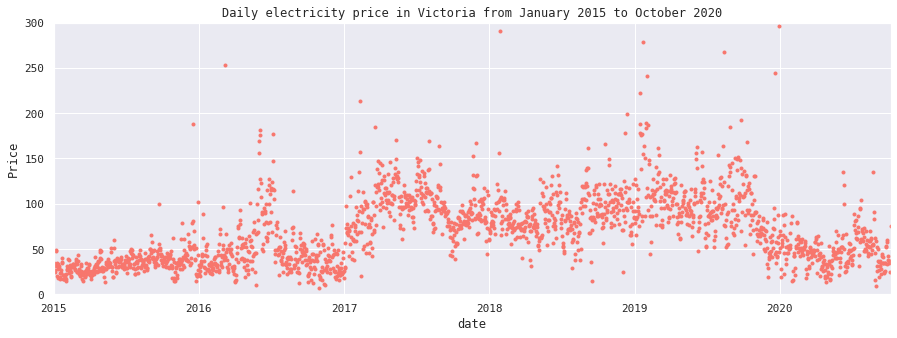

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df_electricity["price"].plot(style='.', figsize=(15,5), color=color_pal[0], title='Daily electricity price in Victoria from January 2015 to October 2020')
plt.ylim(0,300)
plt.ylabel("Price")

## Insights 📍 : The distribution of daily electricity price
Based on the plot above show:

1. The distribution of daily electricity price in Victoria from <span style="background:#fed56f; font-weight:bold; color:black">January 2015 to October 2020 </span>.
2.  There is a significant electricity price change especially in  <span style="background:#fed56f; font-weight:bold; color:black"> 2016 to 2020</span>.

In [4]:
(df_electricity.describe()
 .style
 .highlight_max(axis=0,color="#c07fef")
 .highlight_min(axis=0,color="#00FF00")
 .set_caption("Statistics of Electricity in Australia for 2015-2020"))

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2105.000000,2103.000000
mean,120035.476503,76.079554,119252.305055,76.553847,783.171448,-2.686052,0.008547,11.582289,20.413200,14.743373,1.505944
std,13747.993761,130.246805,14818.631319,130.114184,3578.920686,19.485432,0.039963,4.313711,6.288693,7.945527,4.307897
min,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000
25%,109963.650000,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000
50%,119585.912500,66.596738,119148.082500,66.869058,0.000000,0.000000,0.000000,11.300000,19.100000,12.700000,0.000000
75%,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.700000,0.800000
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,28.000000,43.500000,33.300000,54.600000


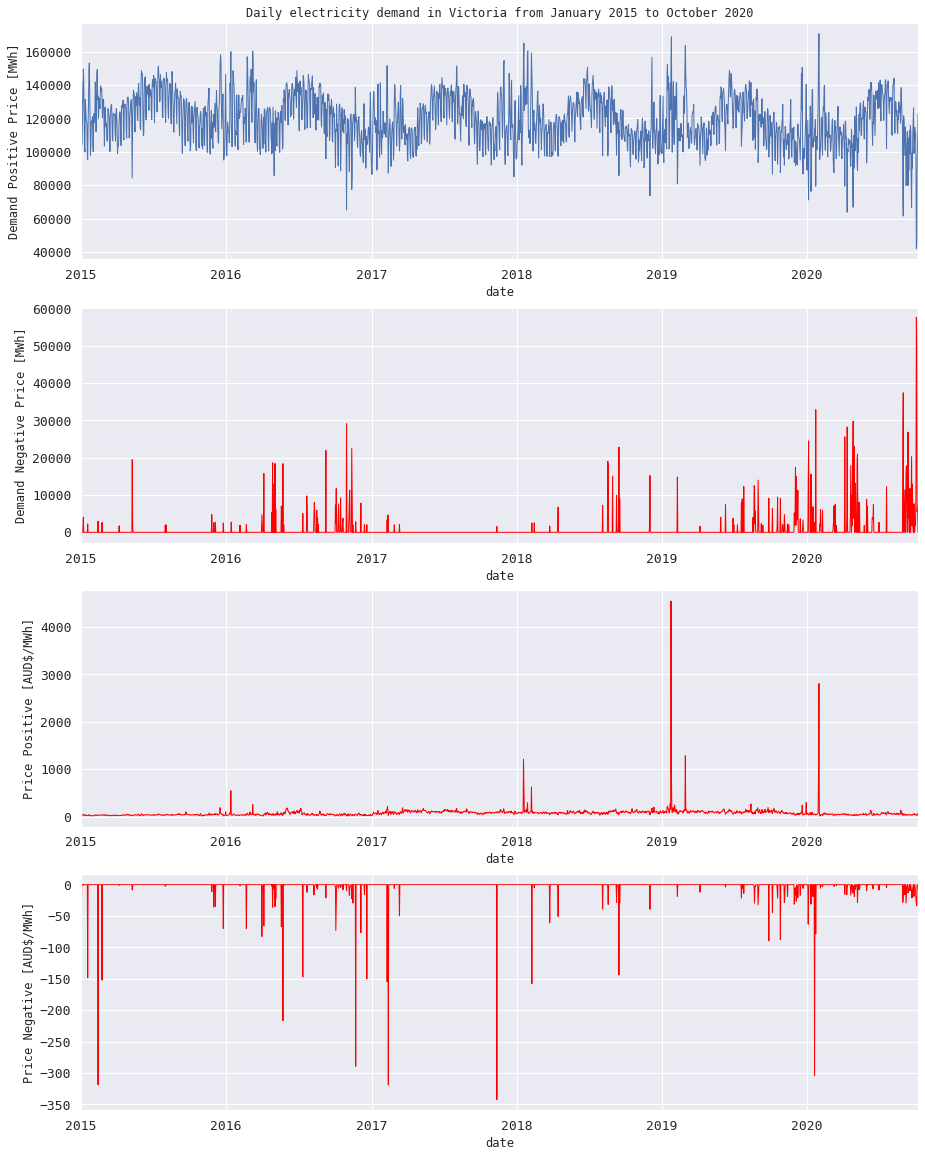

In [5]:
fig, ax = plt.subplots(4, 1, figsize = (15, 20))
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[2].tick_params(axis='both', which='major', labelsize=13)
ax[3].tick_params(axis='both', which='major', labelsize=13)


df_electricity.reset_index().plot(x='date', y='demand_pos_price', lw = 1, ax = ax[0])
ax[0].set_title("Daily electricity demand in Victoria from January 2015 to October 2020")
ax[0].set_ylabel("Demand Positive Price [MWh]")
ax[0].get_legend().remove()


df_electricity.reset_index().plot(x='date', y='demand_neg_price', lw = 1, color='red', ax = ax[1])
ax[1].set_ylabel("Demand Negative Price [MWh]")
ax[1].get_legend().remove()


df_electricity.reset_index().plot(x='date', y='price_positive', lw = 1, color='red', ax = ax[2])
ax[2].set_ylabel("Price Positive [AUD$/MWh]")
ax[2].get_legend().remove()


df_electricity.reset_index().plot(x='date', y='price_negative', lw = 1, color='red', ax = ax[3])
ax[3].set_ylabel("Price Negative [AUD$/MWh]")
ax[3].get_legend().remove()


## Insights 📍 : Daily electricity demand in Victoria from January 2015 to October 2020
Based on the plot above show:

1. <span style="background:#fed56f; font-weight:bold; color:black">Demand positive price</span> shows some seasonality based on plot shown above</span>. Maybe this feature may benefit our model.
2. <span style="background:#fed56f; font-weight:bold; color:black">Demand negative price</span> We can see there is a significant difference electricity price through maximum price which is very far from the mean and standard deviation.
2. <span style="background:#fed56f; font-weight:bold; color:black"> Positive price</span> mostly with small values except for some values that is greater than 1000.
2. <span style="background:#fed56f; font-weight:bold; color:black">Price negative</span>  ocurred in each year with variation of values.

## Make a correlation plot

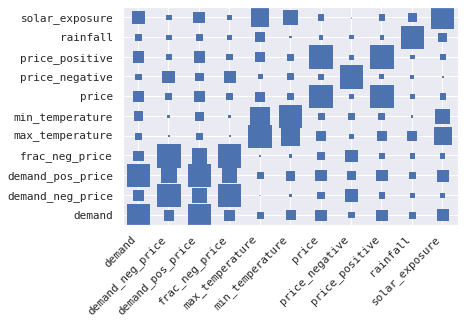

In [6]:
# Make a scatter plot with square markers, set column names as labels
def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
data = df_electricity
columns = df_electricity.columns
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)


## Insights 📍 : Correlation Matrix
Based on the plot above show:

1. Price target has higher correlation with price_positive, demand, demand_pos_price and frac_negative_price.

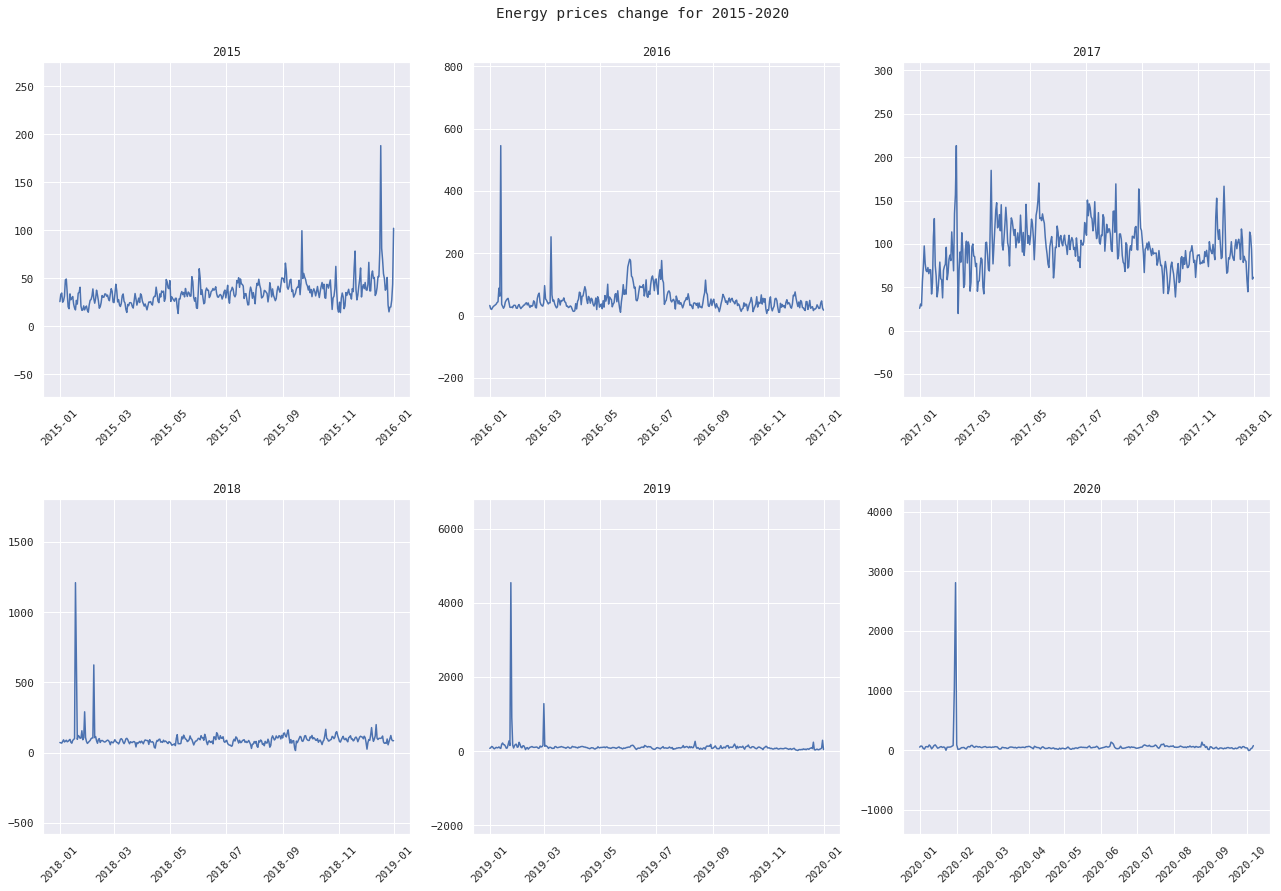

In [7]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df_electricity.groupby([df_electricity.index.year])):
    ax = plt.subplot(2, 3, i+1, ymargin=0.5)
    #print(df.num_sold.values.shape, df.num_sold.values)
    ax.plot(df.price)
    ax.set_title(combi)
    plt.xticks(rotation=45)
plt.tight_layout(h_pad=3.0)
plt.suptitle('Energy prices change for 2015-2020', y=1.03)
plt.show()

## Insights 📍 : Electricity price change
Based on the plot above show:

> 1. There is a significant increase of electricity price in <span style="background:#fed56f; font-weight:bold; color:black">December 2015</span> after a stable price during January-September.
> 2. The electricity price tends to be stable in range <span style="background:#fed56f; font-weight:bold; color:black">50-150 AUD</span> except in <span style="background:#fed56f; font-weight:bold; color:black">February</span> where there is an increase of energy price.
> 2. <span style="background:#fed56f; font-weight:bold; color:black">For 2016</span>, significant increase of price occured in January and March followed by stable price during April-December
> 3. <span style="background:#fed56f; font-weight:bold; color:black">For 2018-2019</span>, There is a significant increase of electricity price around January-February.

Text(0.5, 1.03, 'Energy prices change for 2015-2020 on holiday Season')

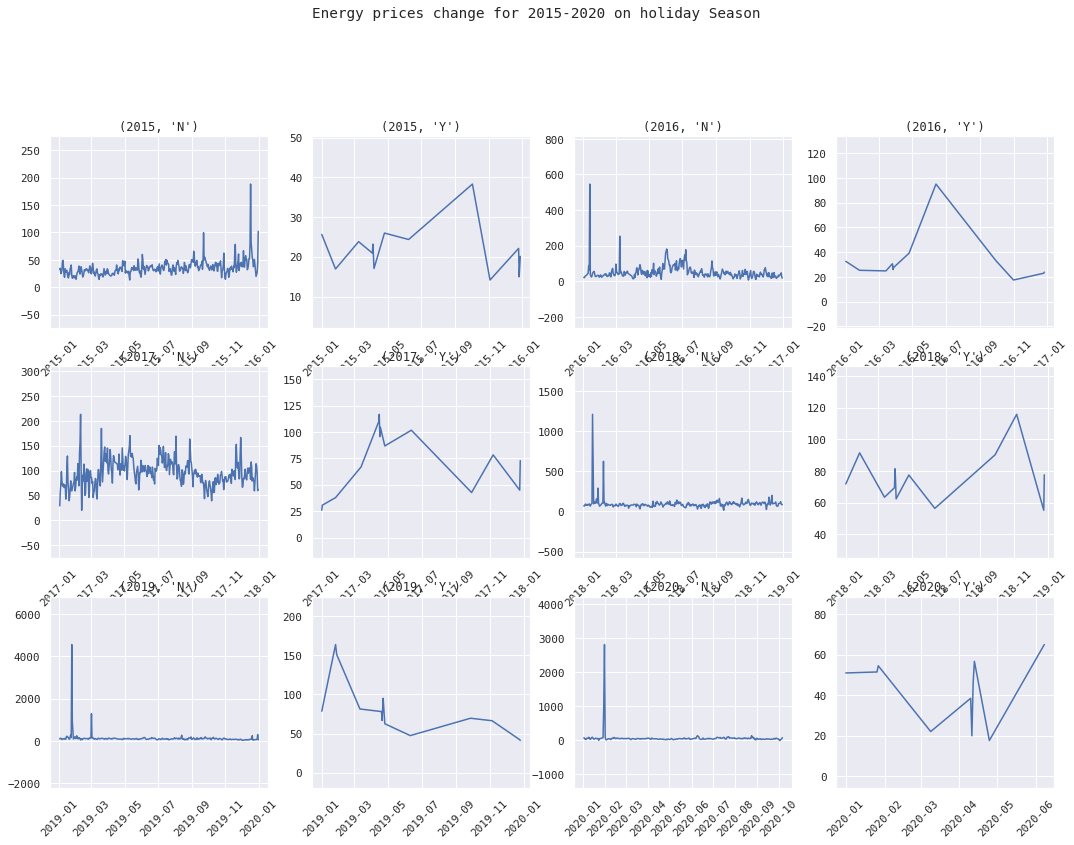

In [8]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df_electricity.groupby([df_electricity.index.year,"holiday"])):
    ax = plt.subplot(3,4, i+1, ymargin=0.5)
    #print(df.num_sold.values.shape, df.num_sold.values)
    ax.plot(df.price)
    ax.set_title(combi)
    plt.xticks(rotation=45)
plt.suptitle('Energy prices change for 2015-2020 on holiday Season', y=1.03)


## Insights 📍 : Electricity prices change for 2015-2020 on holiday Season
Based on the plot above show:

> 1. There is an unstable price pattern of energy price in <span style="background:#fed56f; font-weight:bold; color:black"> holiday season</span>.
> 2. For annual Non-Holiday Season, There is  <span style="background:#fed56f; font-weight:bold; color:black">an increase of energy price in the beginning of the year</span>

Text(0.5, 1.03, 'Energy prices change for 2015-2020 on School Season')

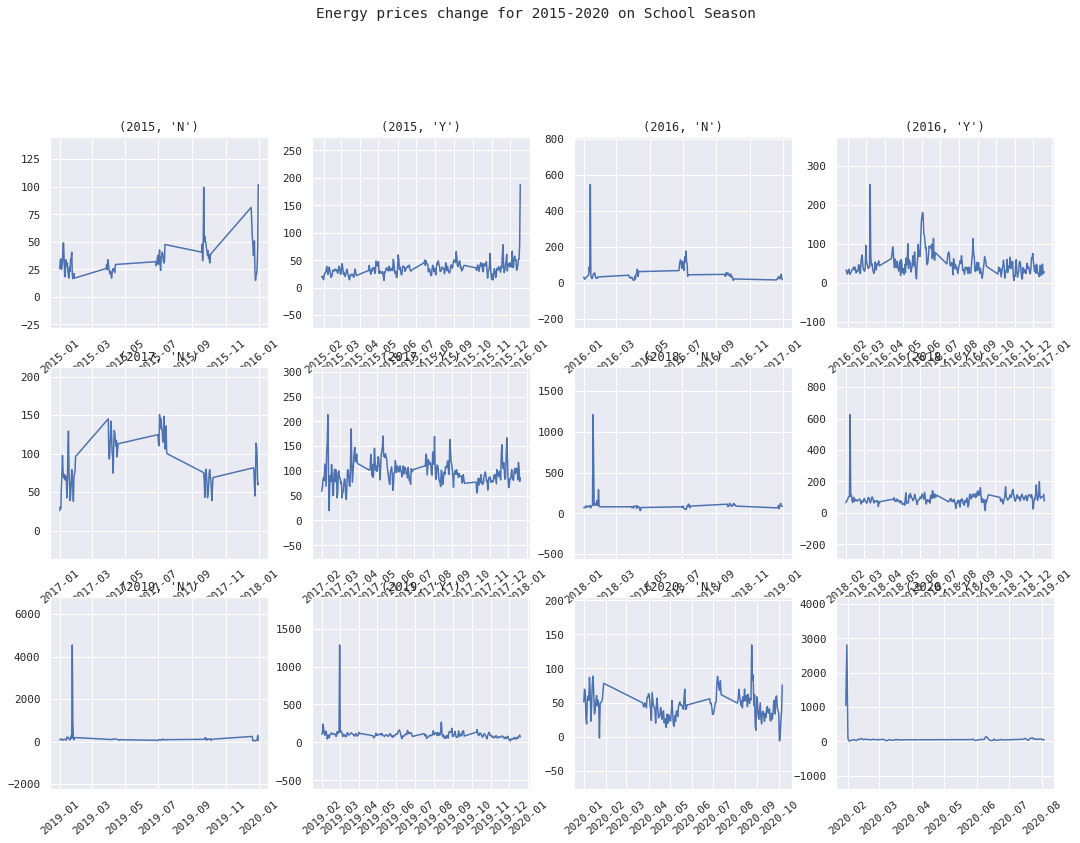

In [9]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df_electricity.groupby([df_electricity.index.year,"school_day"])):
    ax = plt.subplot(3,4, i+1, ymargin=0.5)
    #print(df.num_sold.values.shape, df.num_sold.values)
    ax.plot(df.price)
    ax.set_title(combi)
    plt.xticks(rotation=40)
plt.suptitle('Energy prices change for 2015-2020 on School Season', y=1.03)


## Insights 📍 : Electricity price change for 2015-2020 on School Season
Based on the plot above show:

> 1. There is a <span style="background:#fed56f; font-weight:bold; color:black"> significant increase of electricity price</span> in the end of 2015 on school season
> 2. There is a similar pattern of the increase of electricity price on school season in February-March in <span style="background:#fed56f; font-weight:bold; color:black">2018, 2019, 2020</span>
> 2. For annual non-holiday Season, There is an increase of electricity price in the beginning of the year in  <span style="background:#fed56f; font-weight:bold; color:black">2016, 2018, 2019</span>

## Splitting the data based on time 

In [10]:
split_date = '01-Jan-2019'
df_train = df_electricity.loc[df_electricity.index <= split_date].copy()
df_test = df_electricity.loc[df_electricity.index > split_date].copy()

In [11]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(np.int64) 
    df["school_day"] = pd.get_dummies(df["school_day"])
    df["school_day"] = pd.get_dummies(df["school_day"])
    df['price_7_days_lag'] = df['price'].shift(7)
    df['price_15_days_lag'] = df['price'].shift(15)
    df['price_30_days_lag'] = df['price'].shift(30)
    df['price_7_days_mean'] = df['price'].rolling(window = 7).mean()
    df['price_15_days_mean'] = df['price'].rolling(window = 15).mean()
    df['price_30_days_mean'] = df['price'].rolling(window = 30).mean()
    df['price_7_days_std'] = df['price'].rolling(window = 7).std()
    df['price_15_days_std'] = df['price'].rolling(window = 15).std()
    df['price_30_days_std'] = df['price'].rolling(window = 30).std()
    df['price_7_days_max'] = df['price'].rolling(window = 7).max()
    df['price_15_days_max'] = df['price'].rolling(window = 15).max()
    df['price_30_days_max'] = df['price'].rolling(window = 30).max()
    df['price_7_days_min'] = df['price'].rolling(window = 7).min()
    df['price_15_days_min'] = df['price'].rolling(window = 15).min()
    df['price_30_days_min'] = df['price'].rolling(window = 30).min()
    
 
   
    cols = ['hour','dayofweek','dayofyear','quarter','month','year','dayofmonth','weekofyear','price_positive','demand_pos_price','demand','demand_neg_price','price_negative','frac_neg_price']
    #cols = ['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','demand_pos_price',]
    
    for d in ('7', '15', '30'):
        for c in ('lag', 'mean', 'std', 'max', 'min'):
            cols.append(f'price_{d}_days_{c}')
    X = df[cols]
    if label:
        y = df[label]
        return X, y
    return X

In [12]:
X_train, y_train = create_features(df_train, label='price')
X_test, y_test = create_features(df_test, label='price')

In [13]:
reg = xgb.XGBRegressor(n_estimators=100,eta=0.1)
fitted_xgb_model = reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) 

[0]	validation_0-rmse:78.10893	validation_1-rmse:232.43314
[1]	validation_0-rmse:71.00056	validation_1-rmse:226.20828
[2]	validation_0-rmse:64.59679	validation_1-rmse:220.67781
[3]	validation_0-rmse:58.83662	validation_1-rmse:215.75481
[4]	validation_0-rmse:53.66943	validation_1-rmse:211.30707
[5]	validation_0-rmse:49.02539	validation_1-rmse:207.36438
[6]	validation_0-rmse:44.84808	validation_1-rmse:203.70424
[7]	validation_0-rmse:41.09291	validation_1-rmse:200.41939
[8]	validation_0-rmse:37.70780	validation_1-rmse:197.01788
[9]	validation_0-rmse:34.63074	validation_1-rmse:193.86408
[10]	validation_0-rmse:31.85114	validation_1-rmse:190.97063
[11]	validation_0-rmse:29.33829	validation_1-rmse:188.28787
[12]	validation_0-rmse:27.05840	validation_1-rmse:185.79985
[13]	validation_0-rmse:24.98889	validation_1-rmse:183.49161
[14]	validation_0-rmse:23.10553	validation_1-rmse:181.34113
[15]	validation_0-rmse:21.39121	validation_1-rmse:179.33682
[16]	validation_0-rmse:19.83474	validation_1-rmse:

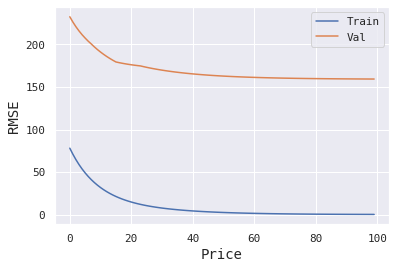

In [14]:
plt.plot(fitted_xgb_model.evals_result()['validation_0']
['rmse'])
plt.plot(fitted_xgb_model.evals_result()['validation_1']
['rmse'])
plt.ylabel('RMSE', fontsize=14)
plt.xlabel('Price', fontsize=14)
plt.legend(['Train', 'Val'], loc='upper right')

We can see the comparison between training rmse and validation rmse score where the is an underfitting problem in our case where maybe due to outlier electricity price in 2019-2020

<AxesSubplot:>

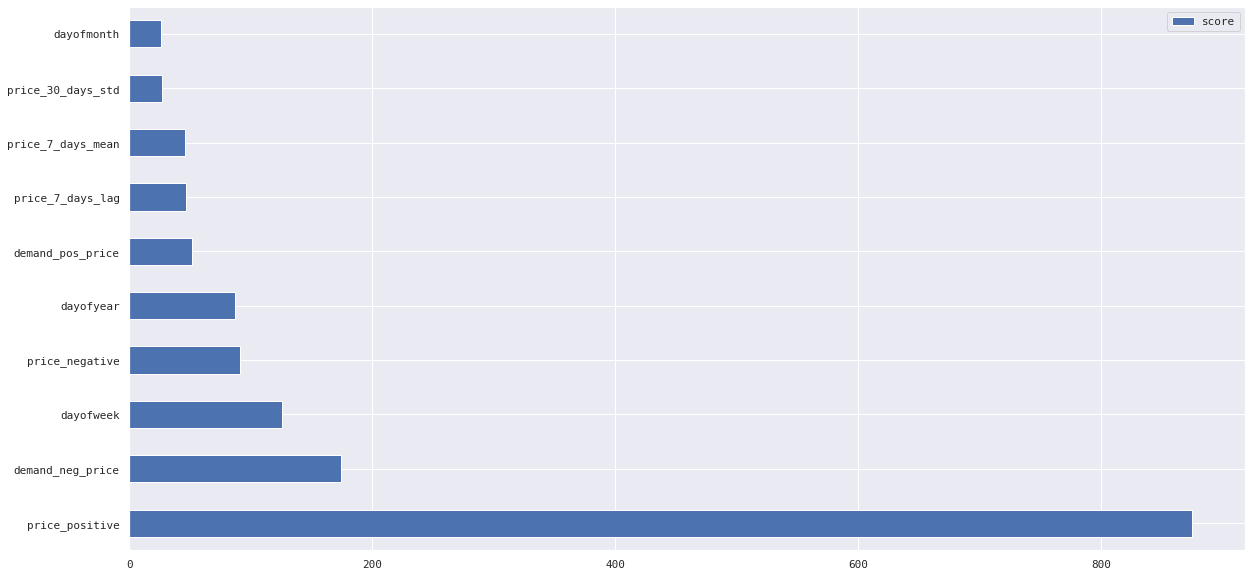

In [15]:
feature_important = reg.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 10 features

Based on the feature importances extracted from the model, price_positive feature, demand_neg_price, dayofweek,dayofyear and dayofyear show the most 5th of feature importances. 

In [18]:

df_test['price_prediction'] = reg.predict(X_test)
price_all = pd.concat([df_test, df_train], sort=False)

(0.0, 1000.0)

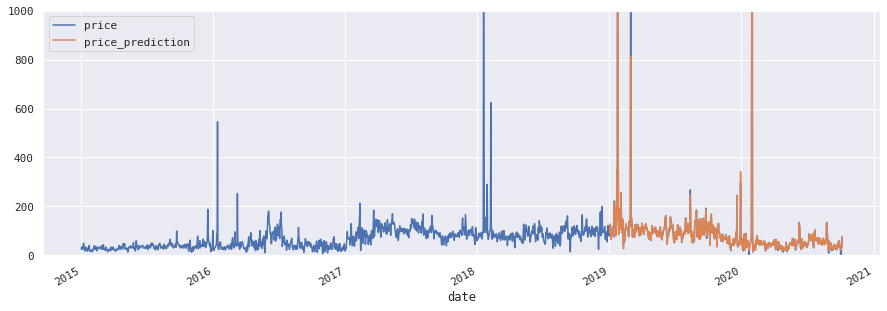

In [19]:
_ = price_all[['price','price_prediction']].plot(figsize=(15, 5))
plt.ylim(0,1000)

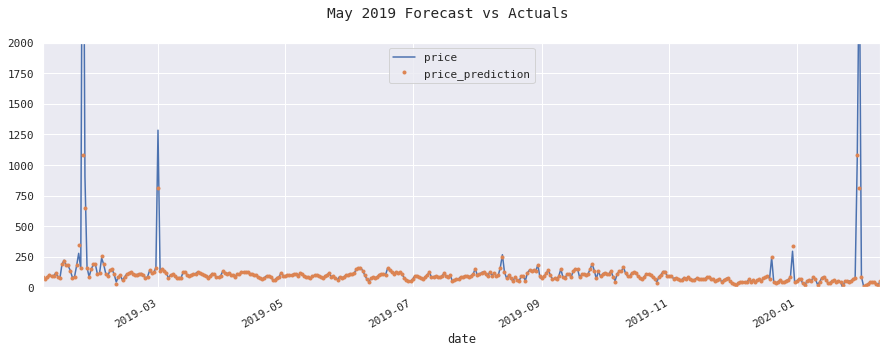

In [20]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = price_all[['price','price_prediction']].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='01-05-2019', upper='02-10-2020')
ax.set_ylim(0, 2000)
plot = plt.suptitle('May 2019 Forecast vs Actuals')

## Insights 📍 : Prediction 
<div class="alert simple-alert">
  <p>Our model is generalizable for the <span style="background:#fed56f; font-weight:bold; color:black">next 12-18 months </span> based on the plot above. In Machine Learninig, It is a mandatory to make our model to be generalizable as possible so that it can predict the real/actual value in real situation. There is a few errors around <span style="background:#fed56f; font-weight:bold; color:black">february and in the beginining of January 2020</span>. If it can predict the same value for actual demand, it is a overfitting problem. We have to take into account this case to make better prediction that can mimic the actual value with fewer errors. </p>
</div>


In [21]:
mean_squared_error(y_true=df_test['price'],y_pred=df_test['price_prediction'])

25369.714397883905

In [22]:
mean_absolute_error(y_true=df_test['price'],y_pred=df_test['price_prediction'])

10.73348890658493

In [23]:
df_test['error'] = df_test['price'] - df_test['price_prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']).mean()[['price','price_prediction','error','abs_error']]

In [24]:
(error_by_day.sort_values('error', ascending=True).head(10)
.style
.bar(subset="error",color="#c07fef",vmax=error_by_day.error.quantile(0.95))
.highlight_max(axis=0,color="#fef70c")
)

In [25]:
# Worst absolute predicted days
(error_by_day.sort_values('abs_error', ascending=False).head(10)
.style
.bar(subset="abs_error",color="#c07fef",vmax=error_by_day.abs_error.quantile(0.95))
.highlight_max(axis=0,color="#fef70c")
)

## Insights 📍 :
Notice anything about the over forecasted days?

- #1 worst day - February 2nd, 2020.
- #6 worst day - March 25, 2019.

Looks like our model influenced by outliers .

In [26]:
# Best predicted days
(error_by_day.sort_values('abs_error', ascending=True).head(10)
.style
.bar(subset="abs_error",color="#c07fef",vmax=error_by_day.abs_error.quantile(0.95))
.highlight_max(axis=0,color="#fef70c")
)

## Revenue generated per year using retail prices and a 70MWh storage system by the energy storage venture

In [27]:
predicton_vs_Actual = df_test.rename(columns={"price":"PRICE","price_prediction":"PRICE_PREDICTION"})
predicton_vs_Actual.head()

,demand,PRICE,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,...,price_30_days_std,price_7_days_max,price_15_days_max,price_30_days_max,price_7_days_min,price_15_days_min,price_30_days_min,PRICE_PREDICTION,error,abs_error
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,106470.675,92.202011,106470.675,92.202011,0.0,0.0,0.0,18.4,22.2,26.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.063560,0.138451,0.138451
2019-01-03,118789.605,127.380303,118789.605,127.380303,0.0,0.0,0.0,15.9,29.5,27.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.187721,1.192581,1.192581
2019-01-04,133288.460,121.020997,133288.460,121.020997,0.0,0.0,0.0,18.0,42.6,27.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.093582,-0.072585,0.072585
2019-01-05,97262.790,83.493520,97262.790,83.493520,0.0,0.0,0.0,17.4,21.2,12.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.704323,-0.210802,0.210802
2019-01-06,93606.215,65.766407,93606.215,65.766407,0.0,0.0,0.0,14.6,22.1,30.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.620796,0.145611,0.145611


In [28]:
# delve into preditiocn demand and actual demand for the next 12-18 months dataset
(predicton_vs_Actual.sample(5)
 .style
 .background_gradient(axis=0,subset=["PRICE","PRICE_PREDICTION"],cmap="Blues")
 .set_caption("Comparison of Real price and Prediction price")
)                       

,demand,PRICE,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,price_7_days_lag,price_15_days_lag,price_30_days_lag,price_7_days_mean,price_15_days_mean,price_30_days_mean,price_7_days_std,price_15_days_std,price_30_days_std,price_7_days_max,price_15_days_max,price_30_days_max,price_7_days_min,price_15_days_min,price_30_days_min,PRICE_PREDICTION,error,abs_error
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-05-09 00:00:00,122003.335000,113.630330,122003.335000,113.630330,0.000000,0.000000,0.000000,9.700000,16.200000,5.300000,0.600000,1,N,2019-05-09 00:00:00,0,3,2,5,2019,129,9,19,103.586615,86.749293,106.335947,106.865733,96.623933,98.522041,7.406591,18.083131,18.599522,114.528451,121.029642,128.723205,94.753714,60.918383,60.918383,113.538170,0.092161,0.092161
2019-05-29 00:00:00,136301.490000,85.003942,132293.375000,87.586358,4008.115000,-0.232263,0.041667,8.700000,10.600000,7.900000,1.200000,1,N,2019-05-29 00:00:00,0,2,2,5,2019,149,29,22,115.894456,89.822692,121.029642,81.525716,89.572279,93.909191,9.681412,13.081572,12.709062,91.547124,115.894456,115.894456,63.903082,63.903082,63.903082,84.263779,0.740164,0.740164
2019-11-19 00:00:00,112033.870000,81.955896,112033.870000,81.955896,0.000000,0.000000,0.000000,11.400000,18.600000,27.900000,0.000000,1,N,2019-11-19 00:00:00,0,1,4,11,2019,323,19,47,57.069846,79.096404,87.533212,71.265329,69.962424,81.502759,5.940118,8.388761,20.512934,81.955896,86.639010,130.318312,64.519389,57.069846,44.849284,81.987778,-0.031882,0.031882
2020-01-04 00:00:00,102245.610000,28.042231,87566.775000,43.312297,14678.835000,-63.051542,0.145833,18.600000,26.800000,22.800000,0.000000,0,N,2020-01-04 00:00:00,0,5,1,1,2020,4,4,1,63.295449,243.810160,45.830326,91.959079,68.719604,70.563091,91.874643,64.578795,56.778238,295.829202,295.829202,295.829202,28.042231,28.042231,28.042231,38.049507,-10.007276,10.007276
2019-01-08 00:00:00,113446.100000,104.907782,113446.100000,104.907782,0.000000,0.000000,0.000000,16.700000,24.100000,28.900000,0.000000,0,N,2019-01-08 00:00:00,0,1,1,1,2019,8,8,2,nan,nan,nan,97.121282,nan,nan,21.929885,nan,nan,127.380303,nan,nan,65.766407,nan,nan,104.949661,-0.041880,0.041880


In [31]:
(predicton_vs_Actual.describe()
 .style
 .highlight_max(axis=0,color="#c07fef")
 .highlight_min(axis=0,color="#00FF00")
 .set_caption("Price for the next 12-18 months dataset")
)

,demand,PRICE,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,price_7_days_lag,price_15_days_lag,price_30_days_lag,price_7_days_mean,price_15_days_mean,price_30_days_mean,price_7_days_std,price_15_days_std,price_30_days_std,price_7_days_max,price_15_days_max,price_30_days_max,price_7_days_min,price_15_days_min,price_30_days_min,PRICE_PREDICTION,error,abs_error
count,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,637.000000,629.000000,614.000000,638.000000,630.000000,615.000000,638.000000,630.000000,615.000000,638.000000,630.000000,615.000000,638.000000,630.000000,615.000000,644.000000,644.000000,644.000000
mean,117643.164884,92.987010,115960.088610,93.920500,1683.076273,-2.628288,0.018763,11.258851,20.047516,14.121429,1.571118,0.579193,0.000000,3.000000,2.310559,5.920807,2019.434783,164.804348,15.633540,24.015528,93.691424,94.312974,95.825203,93.212968,93.538990,91.768173,54.150249,72.852308,87.392116,200.741524,322.505861,494.818502,52.455595,43.836577,36.683321,83.745338,9.241676,10.733489
std,13719.536422,221.045838,16058.351649,220.815258,5468.830434,14.501710,0.061677,4.178613,6.275934,7.527379,4.622587,0.494072,0.000000,2.001555,1.038818,3.204041,0.496114,97.726483,8.830309,13.916315,222.139909,223.477412,225.979776,105.016925,78.052549,55.971449,204.237108,204.005225,183.989880,555.624866,798.388712,1010.230907,26.400018,23.519784,21.738763,83.260063,159.133995,159.040192
min,86891.230000,-6.076028,41988.240000,14.558266,0.000000,-304.150000,0.000000,1.700000,9.600000,1.300000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2019.000000,1.000000,1.000000,1.000000,-1.761423,-1.761423,-1.761423,23.314900,26.399112,30.011994,2.643165,5.364451,8.586690,33.031411,37.881752,53.063441,-6.076028,-6.076028,-6.076028,14.941895,-72.023587,0.000652
25%,107860.791250,47.951427,106688.311250,48.534078,0.000000,0.000000,0.000000,8.300000,15.300000,8.200000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,2019.000000,81.750000,8.000000,12.000000,48.336165,48.542669,49.852245,48.849650,50.822983,52.430808,10.068998,12.243217,15.547400,64.270729,75.818450,103.916022,31.208768,21.755296,18.875436,47.338225,-0.289771,0.100342
50%,115552.020000,70.942903,115005.677500,72.009555,0.000000,0.000000,0.000000,11.000000,18.700000,11.700000,0.000000,1.000000,0.000000,3.000000,2.000000,6.000000,2019.000000,162.000000,16.000000,24.000000,72.065599,72.815311,74.405598,75.313011,83.410650,87.232646,15.213009,18.972156,23.018682,100.676262,125.099031,134.747615,49.910197,44.176312,42.328652,71.584919,-0.011184,0.268921
75%,127321.842500,101.439833,127115.777500,101.665942,0.000000,0.000000,0.000000,13.800000,23.200000,19.300000,1.050000,1.000000,0.000000,5.000000,3.000000,8.000000,2020.000000,242.250000,23.000000,35.000000,101.944171,102.608515,103.262500,103.681588,105.118976,105.963637,24.736949,32.092289,38.685609,134.488422,162.491995,243.810160,75.512742,63.903082,52.525320,101.335741,0.233059,0.588213
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,25.100000,43.500000,32.000000,54.600000,1.000000,0.000000,6.000000,4.000000,12.000000,2020.000000,365.000000,31.000000,52.000000,4549.645105,4549.645105,4549.645105,902.337815,506.831433,318.015562,1663.267896,1140.727552,817.222368,4549.645105,4549.645105,4549.645105,118.261945,89.427805,80.292927,1078.613281,3471.031824,3471.031824


In [32]:
train_df_result =df_train.groupby("year")["price","demand_pos_price","demand_neg_price","frac_neg_price","price_negative","demand"].agg(["mean","max","min"]).stack()
(train_df_result
 .style
 .background_gradient(axis=0,subset=["demand","price"],cmap="Blues")
 .set_caption("Comparison of Real Demand and Prediction Demand")
) 

In [33]:
test_df_result =df_test.groupby("year")["price","demand_pos_price","demand_neg_price","frac_neg_price","price_negative","demand","price_prediction"].agg(["mean","max","min"]).stack()
(test_df_result
 .style
 .background_gradient(axis=0,subset=["price","price_prediction"],cmap="Blues")
 .set_caption("Comparison of Real Demand and Prediction Demand")
) 

In [34]:
test_df_result =df_test.groupby("year")["price","demand_pos_price","demand_neg_price","frac_neg_price","price_negative","demand","price_prediction"].agg(["mean","max","min"]).stack()
(test_df_result
 .style
 .background_gradient(axis=0,subset=["price","price_prediction"],cmap="Blues")
 .set_caption("Comparison of Real Demand and Prediction Demand")
) 

In [35]:
df_electricity["total_price"] = df_electricity["demand"]*df_electricity["price"]

In [36]:
df_electricity.groupby(df_electricity.index.year)["price"].agg(["mean","max","min"]).unstack()

      date
mean  2015      35.068136
      2016      50.094252
      2017      94.740161
      2018      94.648823
      2019     117.281370
      2020      61.266055
max   2015     188.086125
      2016     545.737820
      2017     213.339432
      2018    1210.137920
      2019    4549.645105
      2020    2809.437516
min   2015      13.279841
      2016       6.869135
      2017      19.865114
      2018      14.673588
      2019      19.170951
      2020      -6.076028
dtype: float64

In [37]:
demand_negative_price = df_electricity[df_electricity["price_negative"] < 0]
demand_negative_price

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,total_price
date,,,,,,,,,,,,,,
2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y,2.554014e+06
2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N,4.295012e+06
2015-01-07,153514.820,48.312309,149498.715,49.639712,4016.105,-1.100000,0.020833,18.9,37.4,20.7,0.0,N,N,7.416655e+06
2015-01-18,97728.750,17.008681,95473.965,20.911790,2254.785,-148.260000,0.020833,15.3,19.5,23.4,0.0,N,N,1.662237e+06
2015-02-13,136070.620,18.736971,133078.540,26.322857,2992.080,-318.660000,0.020833,16.1,32.4,14.9,0.0,Y,N,2.549551e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,106641.790,34.654671,95349.610,41.651658,11292.180,-24.426925,0.125000,9.4,19.5,21.2,1.8,N,N,3.695636e+06
2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N,-6.050864e+05
2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N,-1.830288e+05


In [38]:
demand_positive_price = df_electricity[df_electricity["price_negative"] >= 0]
demand_positive_price

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,total_price
date,,,,,,,,,,,,,,
2015-01-03,142300.540,34.564855,142300.540,34.564855,0.0,0.0,0.0,20.0,38.2,26.5,0.0,N,N,4.918598e+06
2015-01-04,104330.715,25.005560,104330.715,25.005560,0.0,0.0,0.0,16.3,21.4,25.2,4.2,N,N,2.608848e+06
2015-01-05,118132.200,26.724176,118132.200,26.724176,0.0,0.0,0.0,15.0,22.0,30.7,0.0,N,N,3.156986e+06
2015-01-06,130672.485,31.282311,130672.485,31.282311,0.0,0.0,0.0,17.7,26.0,31.6,0.0,N,N,4.087737e+06
2015-01-08,142015.655,49.117280,142015.655,49.117280,0.0,0.0,0.0,23.1,28.2,13.5,19.4,N,N,6.975423e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-24,117535.715,51.779356,117535.715,51.779356,0.0,0.0,0.0,8.2,15.0,13.9,1.6,N,N,6.085924e+06
2020-09-25,126354.680,53.429210,126354.680,53.429210,0.0,0.0,0.0,7.2,11.9,7.2,3.2,N,N,6.751031e+06
2020-09-27,101703.490,57.920029,101703.490,57.920029,0.0,0.0,0.0,8.8,13.4,20.9,3.0,N,N,5.890669e+06


In [39]:
demand_negative= (demand_negative_price.groupby(demand_negative_price.index.year)["total_price"].agg(["sum","max","min"])).reset_index()
demand_negative

,date,sum,max,min
0,2015,5.372423e+07,7.416655e+06,1.378597e+06
1,2016,1.369800e+08,8.757394e+06,6.479361e+05
2,2017,6.131691e+07,2.429793e+07,1.768058e+06
3,2018,9.400152e+07,1.594169e+07,1.594026e+06
4,2019,2.664610e+08,1.299868e+07,2.091436e+06
5,2020,1.753889e+08,5.274907e+06,-6.050864e+05


This is the condition when the demand for negative price per year. You can see on 2020 where the minimum price show a negative value. 

In [40]:
demand_positive = demand_positive_price.groupby(demand_positive_price.index.year)["total_price"].agg(["sum","max","min"]).reset_index()
demand_positive

,date,sum,max,min
0,2015,1.574325e+09,2.865799e+07,1.423272e+06
1,2016,2.199841e+09,8.732410e+07,1.395336e+06
2,2017,4.132865e+09,2.961015e+07,2.310782e+06
3,2018,4.143335e+09,1.871455e+08,3.281310e+06
4,2019,5.148785e+09,7.092503e+08,3.965547e+06
5,2020,2.065448e+09,4.794413e+08,1.389527e+06


This is the condition when the demand for positive price per year. You can see on per year where the minimum price show a an appreciation from the market that is shown on the positive electiricity price. 

In [53]:
result = demand_negative.merge(demand_positive,on="date",suffixes =["_demand_pos","_demand_neg"])
result

,date,sum_demand_pos,max_demand_pos,min_demand_pos,sum_demand_neg,max_demand_neg,min_demand_neg
0,2015,5.372423e+07,7.416655e+06,1.378597e+06,1.574325e+09,2.865799e+07,1.423272e+06
1,2016,1.369800e+08,8.757394e+06,6.479361e+05,2.199841e+09,8.732410e+07,1.395336e+06
2,2017,6.131691e+07,2.429793e+07,1.768058e+06,4.132865e+09,2.961015e+07,2.310782e+06
3,2018,9.400152e+07,1.594169e+07,1.594026e+06,4.143335e+09,1.871455e+08,3.281310e+06
4,2019,2.664610e+08,1.299868e+07,2.091436e+06,5.148785e+09,7.092503e+08,3.965547e+06
5,2020,1.753889e+08,5.274907e+06,-6.050864e+05,2.065448e+09,4.794413e+08,1.389527e+06


In [54]:
result["profit"] =result["sum_demand_pos"]-result["sum_demand_neg"]
result

,date,sum_demand_pos,max_demand_pos,min_demand_pos,sum_demand_neg,max_demand_neg,min_demand_neg,profit
0,2015,5.372423e+07,7.416655e+06,1.378597e+06,1.574325e+09,2.865799e+07,1.423272e+06,-1.520601e+09
1,2016,1.369800e+08,8.757394e+06,6.479361e+05,2.199841e+09,8.732410e+07,1.395336e+06,-2.062861e+09
2,2017,6.131691e+07,2.429793e+07,1.768058e+06,4.132865e+09,2.961015e+07,2.310782e+06,-4.071548e+09
3,2018,9.400152e+07,1.594169e+07,1.594026e+06,4.143335e+09,1.871455e+08,3.281310e+06,-4.049333e+09
4,2019,2.664610e+08,1.299868e+07,2.091436e+06,5.148785e+09,7.092503e+08,3.965547e+06,-4.882324e+09
5,2020,1.753889e+08,5.274907e+06,-6.050864e+05,2.065448e+09,4.794413e+08,1.389527e+06,-1.890059e+09


We then substract the result when the demand is positive and demand is negative based on the total price feature that we have been created. Most of the years shows a good result.

In [55]:
(result.sort_values("profit",ascending=False)
 .style
 .background_gradient(axis=0,subset=["profit"],cmap="Blues")
 .set_caption("Revenue Generated per year in the daily electiricity in Victoria Australia")
) 

,date,sum_demand_pos,max_demand_pos,min_demand_pos,sum_demand_neg,max_demand_neg,min_demand_neg,profit
0,2015,53724226.195450,7416655.478100,1378597.267300,1574325245.732850,28657986.984200,1423271.624550,-1520601019.537400
5,2020,175388922.414300,5274906.749050,-605086.358650,2065448006.418448,479441300.280350,1389526.980150,-1890059084.004148
1,2016,136979985.293800,8757393.861900,647936.058000,2199840903.512048,87324095.189800,1395335.785200,-2062860918.218248
3,2018,94001516.532700,15941690.363300,1594026.374700,4143334845.374103,187145487.765800,3281310.303700,-4049333328.841403
2,2017,61316908.492550,24297929.587900,1768057.715850,4132864954.688900,29610145.615450,2310781.730750,-4071548046.196351
4,2019,266461002.062250,12998679.984000,2091436.460650,5148785149.602045,709250294.674700,3965547.099050,-4882324147.539795


This is the result of revenue generated per year. We can see a good revenue generated per year. If you find this notebook usefull, Please show your appreciation by upvoting this notebook. Thank you.